<a href="https://colab.research.google.com/github/bfink83/pinned_field_position_project/blob/main/pinned_field_position_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install nfl_data_py
!pip install os
!pip install pandas
!pip install matplotlib

In [2]:
import pandas as pd
import nfl_data_py as nfl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import seaborn as sns
import os
import urllib.request
import numpy as np

With the Buffalo Bills being Super Bowl favorites last year, I followed them closely. While watching them, I witnessed in all likelihood both the best (Week 5 J. Allen to G. Davis for 98 yd TD) and worst (Week 10 J. Allen fumble on QB sneak for MIN DEF TD) plays of the season for teams pinned near their own goal line. The duality of these two plays, a shotgun 5-step-drop pass versus an under-center quarterback sneak made me want to research NFL teams' strategies while pinned, something that I don't see very often, if at all, on football analytics Twitter. So, here's my first official attempt at football analytics:

#Import data using `nfl_data_py` library.

We will be using data from the past 10 years.

In [3]:
pbp = nfl.import_pbp_data([2013, 2014, 2015, 2016, 2017,2018, 2019, 2020, 2021, 2022])

2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


#Change options to view all column names in dataframe.

In [4]:
pd.set_option('display.max_columns', None)

#Filter out special teams and 'no play' entries from data

In [5]:
pbp_rp = pbp.loc[(pbp['play_type'] == 'run') | (pbp['play_type'] == 'pass')].copy()

#Add our own unique `drive_id` and `series_id` columns so that we can easily filter out consecutive drives/series.

In [6]:
pbp_rp['drive_id'] = (pbp_rp['old_game_id'].astype(str) + pbp_rp['fixed_drive'].astype(int).astype(str)).astype(int)
pbp_rp['series_id'] = (pbp_rp['old_game_id'].astype(str) + pbp_rp['series'].astype(int).astype(str)).astype(int)

#Create new dataframe with relevant columns

In [7]:
df = pbp_rp[['play_id', 'drive_id', 'series_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'posteam', 'down', 'series', 'side_of_field', 'yardline_100', 'yrdln', 'ydstogo', 
           'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'safety_prob', 'ep', 'epa', 'total_home_epa', 'total_away_epa',
           'wp', 'wpa', 'drive_play_id_started', 'drive_play_count',
           'fixed_drive', 'fixed_drive_result', 'drive_first_downs', 'series_success', 'series_result', 'drive_end_transition', 'drive_end_yard_line', 
           'drive_start_yard_line', 'possession_team','incomplete_pass', 'pass', 'pass_oe', 'penalty', 'penalty_yards', 'penalty_type']]

#Just for fun, here are the two plays I was referring to in the introduction:

In [8]:
df.loc[(df.yardline_100.ge(95.0) & df.yards_gained.gt(95) & df.possession_team.eq('BUF')) | df.yardline_100.ge(95.0) & df.fixed_drive_result.eq('Opp touchdown') & df.possession_team.eq('BUF')]

,play_id,drive_id,series_id,game_id,old_game_id,home_team,away_team,posteam,down,series,side_of_field,yardline_100,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,safety_prob,ep,epa,total_home_epa,total_away_epa,wp,wpa,drive_play_id_started,drive_play_count,fixed_drive,fixed_drive_result,drive_first_downs,series_success,series_result,drive_end_transition,drive_end_yard_line,drive_start_yard_line,possession_team,incomplete_pass,pass,pass_oe,penalty,penalty_yards,penalty_type
451188,117.0,20221009011,20221009011,2022_05_PIT_BUF,2022100901,BUF,PIT,BUF,3.0,1.0,BUF,98.0,BUF 2,10.0,98.0,(14:09) (Shotgun) 17-J.Allen pass deep middle ...,pass,98.0,1.0,0.001405,-1.357653,8.357654,5.525902,-5.525902,0.481161,0.216355,42.0,3.0,1.0,Touchdown,1.0,1.0,Touchdown,TOUCHDOWN,BUF 2,BUF 2,BUF,0.0,1.0,12.774670,0.0,NaN,None
463693,4241.0,202211130122,202211130157,2022_10_MIN_BUF,2022111301,BUF,MIN,BUF,1.0,57.0,BUF,99.0,BUF 1,10.0,-1.0,(:49) 68-B.Hart reported in as eligible. 17-J...,run,0.0,0.0,0.000249,-0.170184,-6.829816,-5.357606,5.357606,0.927179,-0.740489,4241.0,1.0,22.0,Opp touchdown,0.0,0.0,Opp touchdown,FUMBLE,BUF 1,BUF 1,BUF,0.0,0.0,-4.681446,0.0,NaN,None


#Filter data to get plays that started within possesion team's 5 yard line

In [9]:
df_pinned = df.loc[df.yardline_100.ge(95.0) & df.down.le(3.0)].copy()

#Create dataframe with ***drive result*** indexed by `drive_id`, so we can see the distribution of drive results for drives that had at least one play within the possession team's own 5 yard line.

In [10]:
df_drive_results = df_pinned[['drive_id', 'fixed_drive_result']].copy()
df_drive_results.drop_duplicates(inplace=True)
num_drives = df_drive_results.shape[0]
num_safeties = df_drive_results['fixed_drive_result'].value_counts()['Safety']

#Plot drive result distribution to visualize results

In [11]:
drive_result_counts = df_drive_results['fixed_drive_result'].value_counts().sort_values(ascending=True)

pinned_drives = df_pinned['drive_id']
ensuing_drives = pinned_drives.add(1)

df_next_drive = df[df['drive_id'].isin(ensuing_drives)]

df_next_drive_results = df_next_drive[['drive_id', 'fixed_drive_result']].copy()
df_next_drive_results.drop_duplicates(inplace=True)

next_drive_result_counts = df_next_drive_results['fixed_drive_result'].value_counts()
next_drive_result_counts['Safety'] = 0
next_drive_result_counts = next_drive_result_counts.sort_values(ascending=True)

As you can see below on the left graph, when a team is pinned, it is almost six times as likely to punt that ball than any other result. Meanwhile, the opposing team is more than twice as likely to score points on the next possession than the team that is pinned. So, it is clear that getting out of this situation can be crucial to winning games.

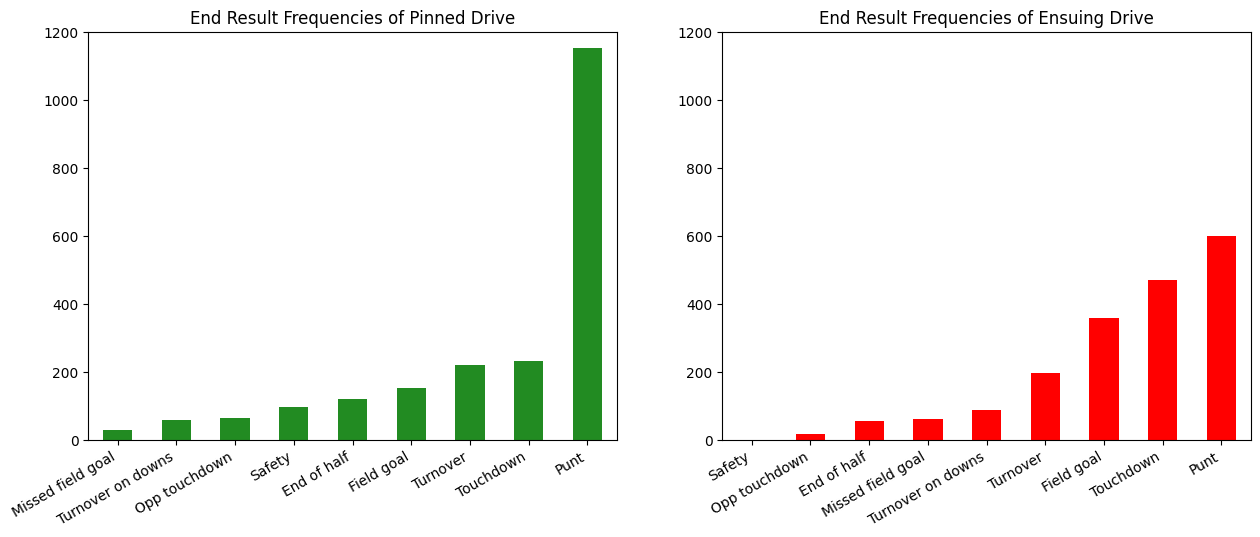

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
drive_result_counts.plot(ax=ax[0], kind='bar', color='forestgreen', title='End Result Frequencies of Pinned Drive')
next_drive_result_counts.plot(ax=ax[1], kind='bar', color='red', title='End Result Frequencies of Ensuing Drive')
for i in range(2):
  ax[i].set_ylim(0, 1200)
fig.autofmt_xdate();

Let's look at the number of occurences of each result next to each other for more clarity. As you can see, being pinned is not only unsafe for that drive, but it makes the opposition's next drive much easier as well. So, being pinned near your own goal line has an effect on not one but two drives.

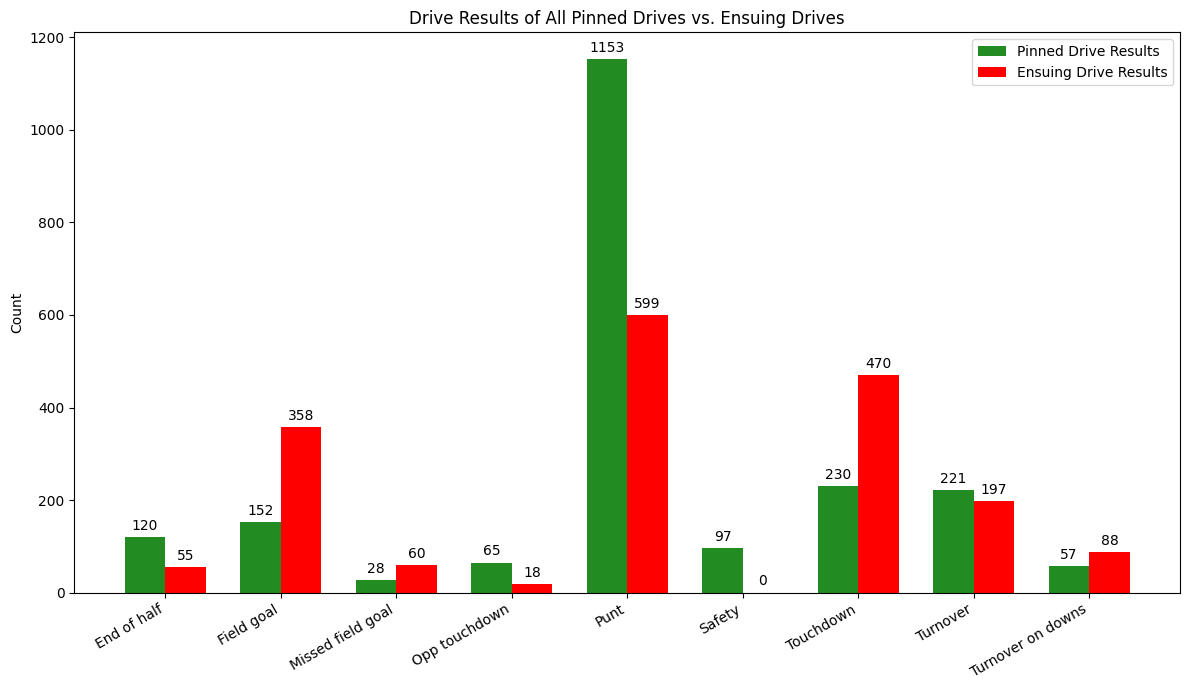

In [13]:
ind = np.arange(len(drive_result_counts))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (12,7))
rects1 = ax.bar(ind - width/2, drive_result_counts.sort_index(), width,
                label='Pinned Drive Results', color='forestgreen')
rects2 = ax.bar(ind + width/2, next_drive_result_counts.sort_index(), width,
                label='Ensuing Drive Results', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Drive Results of All Pinned Drives vs. Ensuing Drives')
ax.set_xticks(ind)
ax.set_xticklabels(drive_result_counts.sort_index().index)
fig.autofmt_xdate()
ax.legend()

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

autolabel(rects1, "center")
autolabel(rects2, "center")
fig.tight_layout()
plt.show()

#Next, let's look at efficiency of run plays versus pass plays when teams are backed up.

In [14]:
df_epa = df_pinned[['play_type', 'epa', 'incomplete_pass', 'yards_gained']].copy()
epa_incomplete = df_epa.loc[df_epa['play_type'].eq('pass') & df_epa['yards_gained'].eq(0.0), 'epa'].mean()
epa_run_no_gain = df_epa.loc[df_epa['play_type'].eq('run') & df_epa['yards_gained'].eq(0.0), 'epa'].mean()

avg_pass_epa = df_epa.loc[df_epa['play_type'].eq('pass'), 'epa'].mean()
avg_run_epa = df_epa.loc[df_epa['play_type'].eq('run'), 'epa'].mean()

df_wpa = df_pinned[['play_type', 'wpa', 'incomplete_pass', 'yards_gained']].copy()
wpa_incomplete = df_wpa.loc[df_wpa['play_type'].eq('pass') & df_wpa['yards_gained'].eq(0.0), 'wpa'].mean()
wpa_run_no_gain = df_wpa.loc[df_wpa['play_type'].eq('run') & df_wpa['yards_gained'].eq(0.0), 'wpa'].mean()

avg_pass_wpa = df_wpa.loc[df_wpa['play_type'].eq('pass'), 'wpa'].mean()
avg_run_wpa = df_wpa.loc[df_wpa['play_type'].eq('run'), 'wpa'].mean()

The graphs below show the distribution of EPA (top) and WPA (bottom) on plays that started within the possesion team's own 5 yard line. I've split the data between run and pass plays to help determine which strategy is optimal when backed up and to try to support my observations of the dichotomy of the two Bills plays.

All four distributions feature peaks that are slightly negative, which makes sense because due to the nature of the field position, a vast majority of plays will lead to the opposing team having a better chance of scoring and therefore winning. However, we can see the difference in strategies in the tails of each distribution. The much larger right tail for pass plays represents a higher likelihood of a great outcome resulting from a pass play. Because passing plays have both a larger right tail and shorter overall peak, it follows that more passing plays turned out to be great plays than run plays in both pure volume and percentage of their respective play types.

Now, the classic argument to this is, "Well, yes there are more positive outcomes from passing, but it is also much riskier and leads to more negative outcomes as well." While the data does support this to an extent, the marginal risk is actually much less than the potential reward. As seen below, the left tails for passing on each plot is only slightly larger than the left tails of the "conservative" run play plots, compared to the much larger right tails of each plot.

After plotting each distribution, I overlayed the plots with average values for pass and run EPA and WPA overall and average EPA and WPA of 0 yard gains for each play type. Pictured below, passing actually has a slightly positive average EPA, and its average EPA and WPA are both significantly higher than that of run plays. However, the average 0 yard gain lines demonstrate that passing is still riskier because a 0 yard gain while passing the ball has a much lower EPA and slightly lower WPA than running plays.

TL;DR--

Passing has a much higher probability of positive outcomes and only slightly higher probability of negative outcomes. Running plays are definitely the conservative choice, but passing plays risk-reward outweighs the conservativeness of running plays because of its skew towards positive outcomes.

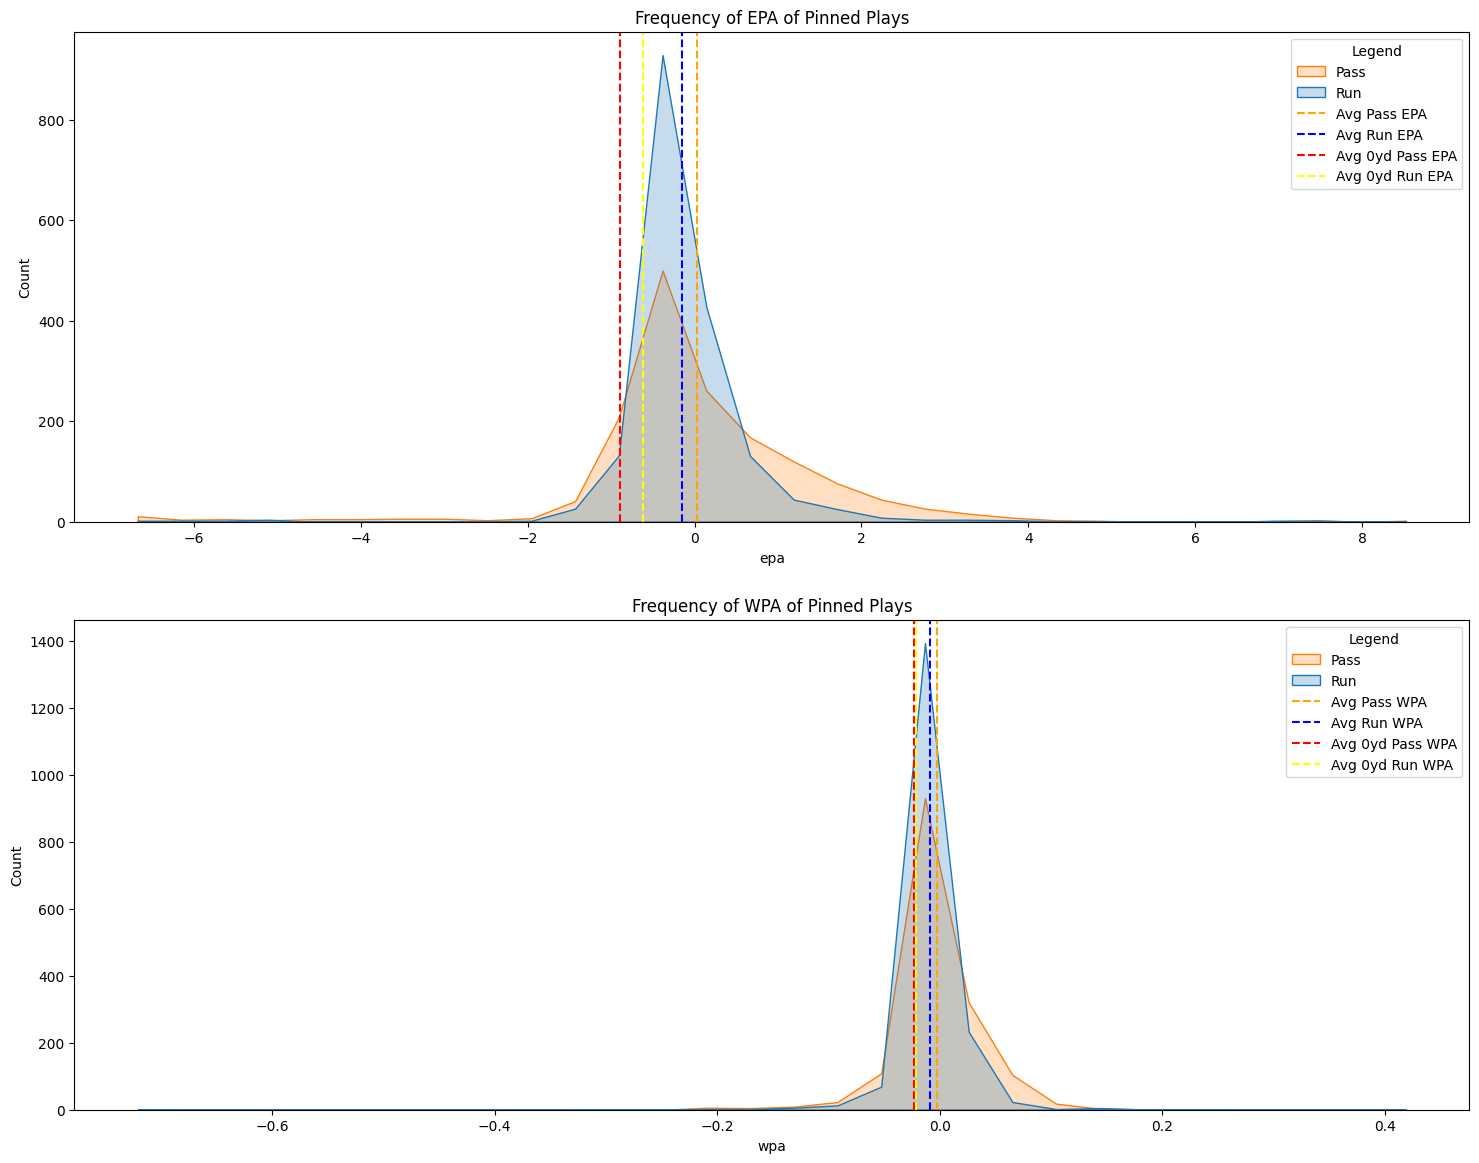

In [15]:
fig, ax = plt.subplots(2,1, figsize=(18,14))

sns.histplot(data=df_epa, x='epa', hue='play_type', hue_order=['run', 'pass'], element='poly', bins=30, ax=ax[0])
sns.histplot(data=df_wpa, x='wpa', hue='play_type', hue_order=['run', 'pass'], element='poly', bins=30, ax=ax[1])

ax[0].set_title('Frequency of EPA of Pinned Plays')
ax[0].axvline(x=avg_pass_epa, linestyle='--', color='orange')
ax[0].axvline(x=avg_run_epa, linestyle='--', color='blue')
ax[0].axvline(x=epa_incomplete, linestyle='--', color='red')
ax[0].axvline(x=epa_run_no_gain, linestyle='--', color='yellow')
ax[0].legend(title='Legend', labels=['Pass', 'Run', 'Avg Pass EPA', 'Avg Run EPA', 'Avg 0yd Pass EPA', 'Avg 0yd Run EPA'])


ax[1].set_title('Frequency of WPA of Pinned Plays')
ax[1].axvline(x=avg_pass_wpa, linestyle='--', color='orange')
ax[1].axvline(x=avg_run_wpa, linestyle='--', color='blue')
ax[1].axvline(x=wpa_incomplete, linestyle='--', color='red')
ax[1].axvline(x=wpa_run_no_gain, linestyle='--', color='yellow')
ax[1].legend(title='Legend', labels=['Pass', 'Run', 'Avg Pass WPA', 'Avg Run WPA', 'Avg 0yd Pass WPA', 'Avg 0yd Run WPA']);



## Now, lets look at this same data in the form of a boxplot.

This visualization tells much the same story as above. While being marginally riskier than running the ball, the reward is much greater with a much larger inter-quartile range on the right side for passing. Overall, you can see that passing has more variance, but it is also disproportionately skewed towards more positive outcomes.

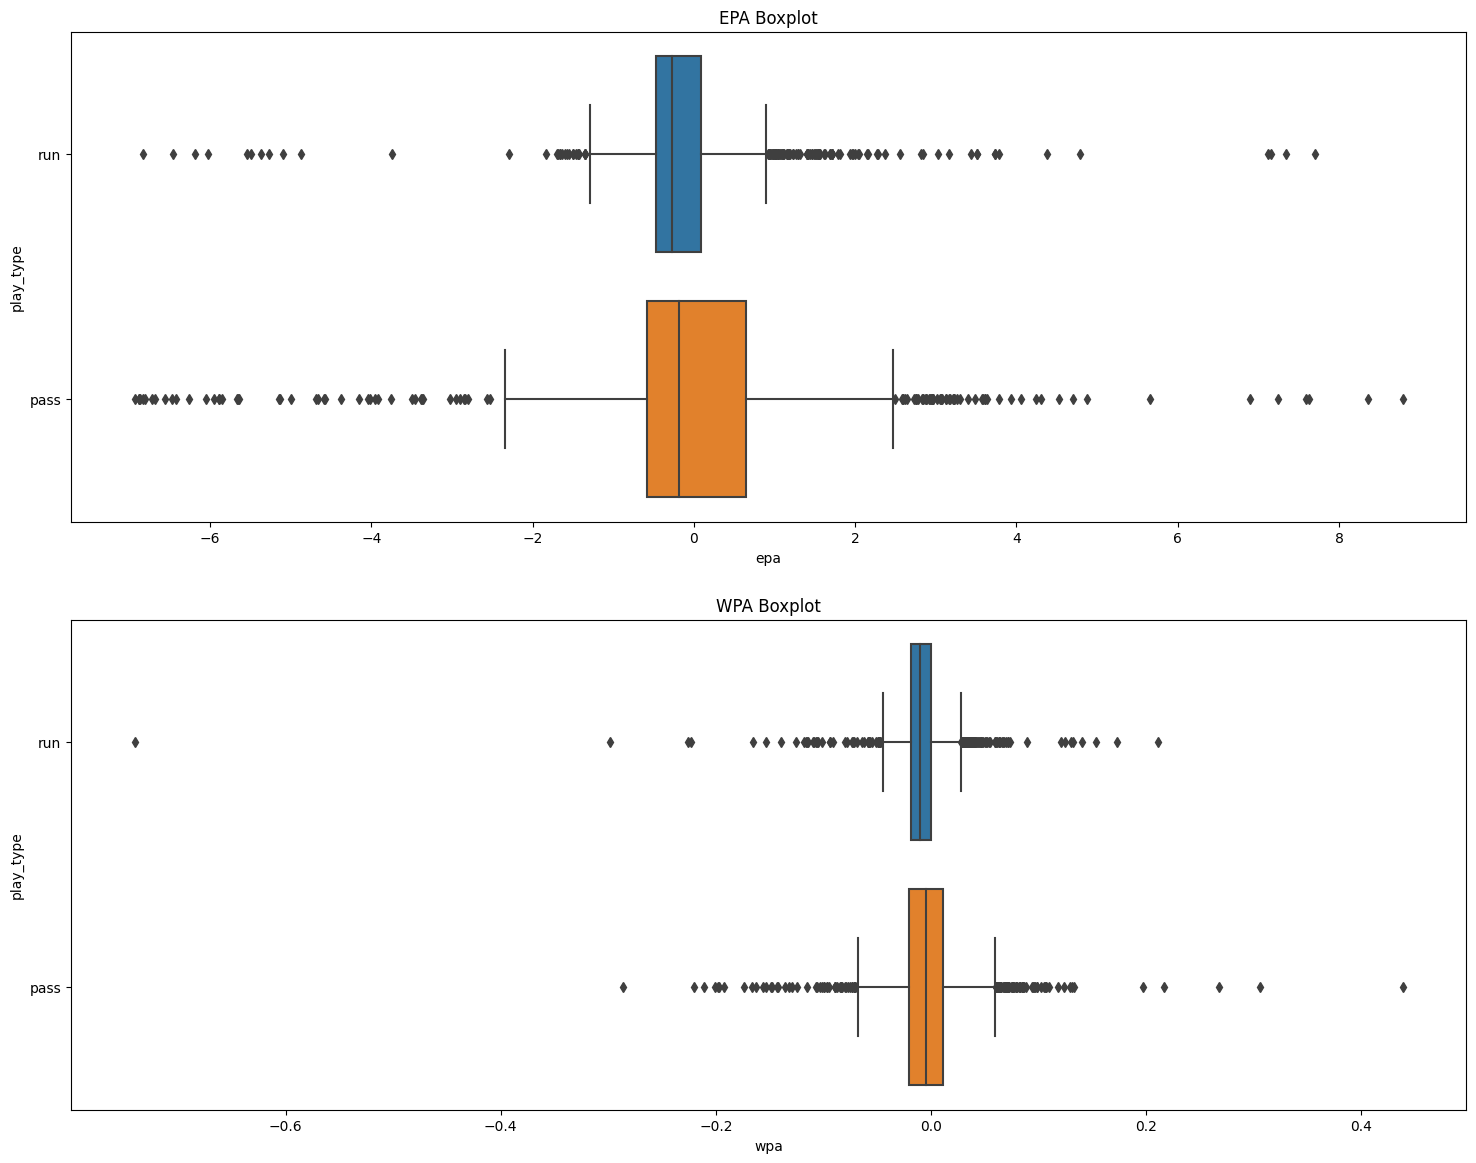

In [16]:
fig, ax = plt.subplots(2,1, figsize=(18,14))
ax[0].set_title('EPA Boxplot')
sns.boxplot(data=df_epa, x="epa", y="play_type", ax=ax[0])
ax[1].set_title('WPA Boxplot')
sns.boxplot(data=df_wpa, x="wpa", y="play_type", ax=ax[1]);

#Now, let's separate the drive results of the ensuing drives by initial drives that gained a first down versus those that did not.

In [17]:
df_drive_results_2 = df_pinned[['drive_id', 'fixed_drive_result', 'drive_first_downs']].copy()
df_drive_results_2.drop_duplicates(inplace=True)
num_drives = df_drive_results_2.shape[0]

df_no_first_down = df_drive_results_2[df_drive_results_2['drive_first_downs'].eq(0)]
df_first_downs = df_drive_results_2[df_drive_results_2['drive_first_downs'].gt(0)]
num_first_downs = df_first_downs.shape[0]

print(f'First down percentage: {100*num_first_downs/num_drives:.2f}%')

first_down_1 = np.where(df_drive_results_2['drive_first_downs'] >= 1, 'First Down', 'No First Down')
df_drive_results_split = df_drive_results_2.groupby(first_down_1)['fixed_drive_result'].value_counts()

First down percentage: 55.82%


In [18]:
df_next_drive_results_2 = df_next_drive[['drive_id', 'fixed_drive_result', 'drive_first_downs']].copy()
df_next_drive_results_2.drop_duplicates(inplace=True)

next_drives = df_next_drive_results_2['drive_id']
prev_drives = next_drives.add(-1)

df_og_drive = df_drive_results_2[df_drive_results_2['drive_id'].isin(prev_drives)]

first_down_2 = np.where(df_og_drive['drive_first_downs'] >= 1, 'First Down', 'No First Down')
df_next_drive_results_split = df_next_drive_results_2.groupby(first_down_2)['fixed_drive_result'].value_counts()

Now, we are going one step further than the initial exploratory data analysis performed in the first step and try to look at the significance of gaining a first down when backed up. The top two charts don't really reveal any information. They are just there for context. The bottom two charts, however, show that the opposing team is almost twice as likely to punt on their next possesion when the backed up team gains at least one first down. Moreover, the opposition's most likely outcome is a touchdown when the pinned team does not gain a first down. From this, it is clear that gaining at least one first down is critical when in a backed up position.

So, this begs the question: what is the best strategy for picking up that first first down?

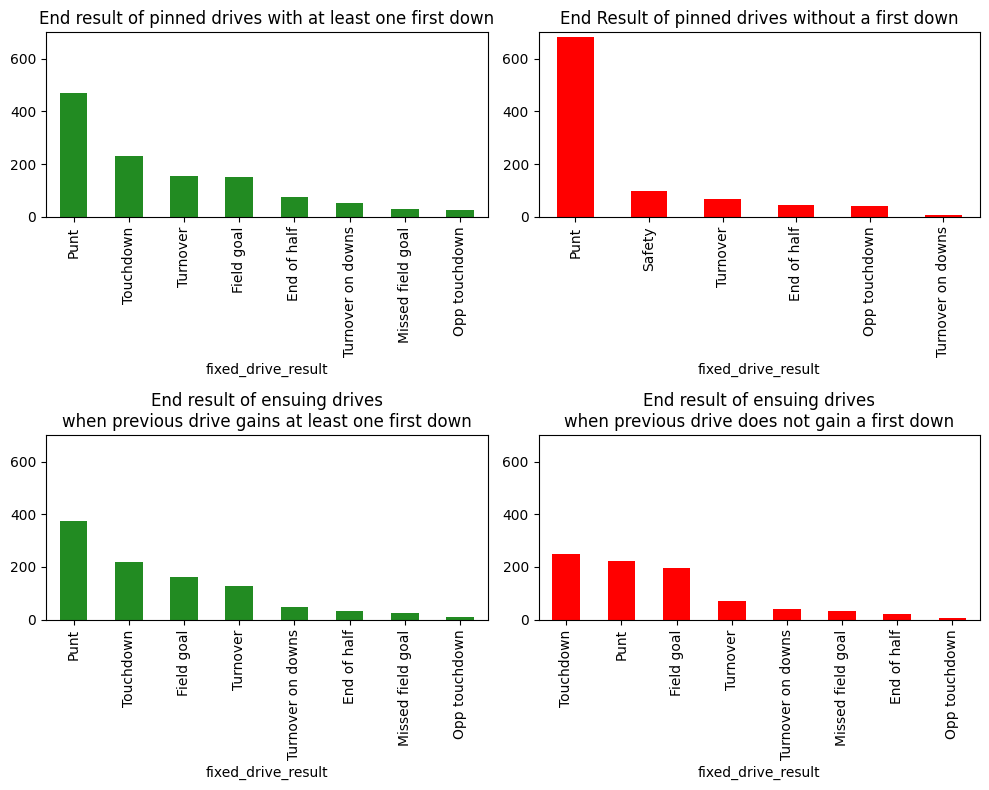

In [19]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
df_drive_results_split['First Down'].plot(ax=ax[0,0], kind='bar', color='forestgreen', title='End result of pinned drives with at least one first down')
ax[0,0].tick_params(axis='x')
df_drive_results_split['No First Down'].plot(ax=ax[0,1], kind='bar', color='red', title='End Result of pinned drives without a first down')
ax[0,1].tick_params(axis='x')

df_next_drive_results_split['First Down'].plot(ax=ax[1,0], kind='bar', color='forestgreen', title="End result of ensuing drives\nwhen previous drive gains at least one first down")
ax[1,0].tick_params(axis='x')
df_next_drive_results_split['No First Down'].plot(ax=ax[1,1], kind='bar', color='red', title="End result of ensuing drives\nwhen previous drive does not gain a first down")
ax[1,1].tick_params(axis='x')
fig.tight_layout()

for i in range(2):
  for j in range (2):
    ax[i][j].set_ylim(0, 700)



From the above bar charts, it is obvious that gaining at least one first down makes an enormous difference in the immediate future of the game. So, let's explore whether running or passing is more likely to gain that first first down.

# First we'll try to find series' success rates grouped by the number of passes thrown on the series.

In [20]:
pinned_series = df_pinned['series_id']

df_first_series = df[df['series_id'].isin(pinned_series)].copy()    #filter for pinned series
df_first_series = df_first_series[df_first_series['penalty'].eq(0.0)]   #filter out any plays that were repeated due to penalties
df_first_series = df_first_series[df_first_series['down'].le(3.0)]    #filter out any 4th down plays because logically they were most likely not called run or pass plays (i.e. fumbled snap, etc.)
df_first_series = df_first_series[df_first_series['series_id'].ne(20121223087)]   #this drive specifically is not usable because two fumbles occured on one play, resetting the downs but not changing series

df_first_series['series_id'].value_counts()    #check play counts to make sure each series has at most 3 plays


202301290014    3
201612110148    3
202012100020    3
20170917118     3
201709171234    3
               ..
201912290535    1
201810140255    1
202101031139    1
201912291012    1
201710150749    1
Name: series_id, Length: 2119, dtype: int64

In [21]:
df_fs_plays = df_first_series[['series_id', 'play_type']]

# binary encode play types to be able to find pass rate for each series: pass=1, run=0
encode = {"play_type" : {"run": 0, "pass": 1}}
df_fs_plays = df_fs_plays.replace(encode)

# get number of passes for each series
df_fs_passes = df_fs_plays.groupby(['series_id']).sum()
df_fs_passes.reset_index(inplace=True)
df_fs_passes.rename(columns={"play_type": "num_passes"}, inplace=True)

In [22]:
df_fs_success = df_first_series[['series_id', 'series_success']]
df_fs_success = df_fs_success.groupby('series_id').mean()
df_fs_success = df_fs_success.merge(df_fs_passes, on='series_id')

As you can see below, it appears that the number of passes thrown has an inverse relationship with series success rate (1st down or TD). However, this is a version of the survivorship bias. A first down becomes decreasingly likely with more passes thrown because if you've thrown `x` passes then you only have `3 - x` plays left to pick up a first down. Basically, series that make it to 4th down "survive" longer in this analysis, so they have more opportunities for throws. Thus, more throws leads to a decreasing success rate. So, due to the bias, these numbers don't necessarily reflect that passing more is bad for picking up a first down. Rather, without proper context they show that running more plays within the same set of downs makes it less likely to pick up a first down. However, with proper context this information could actually show us what we're looking for.

In [23]:
df_fs_success = df_fs_success[['series_success', 'num_passes']]
df_fs_success.groupby('num_passes').mean()

,series_success
num_passes,
0,0.663736
1,0.611805
2,0.420622
3,0.406977


To prove the survivorship bias, we can see the same trend with running plays. As the number of running plays increases, the likelihood of picking up a first down decreases. Since both play types have the same trend, it is clear that this bias is present. However, this run play data also provides us with the context that we needed above to see which play type is more likely to pick up the all-important first down.

In [24]:
df_fs_runs = df_first_series[['series_id', 'play_type']]

# binary encode play types to be able to find pass rate for each series: pass=1, run=0
encode = {"play_type" : {"run": 1, "pass": 0}}
df_fs_runs = df_fs_runs.replace(encode)

# get number of passes for each series
df_fs_runs = df_fs_runs.groupby(['series_id']).sum()
df_fs_runs.reset_index(inplace=True)
df_fs_runs.rename(columns={"play_type": "num_runs"}, inplace=True)

df_fs_runs

df_fs_success_r = df_first_series[['series_id', 'series_success']]
df_fs_success_r = df_fs_success_r.groupby('series_id').mean()
df_fs_success_r = df_fs_success_r.merge(df_fs_runs, on='series_id')

df_fs_success_r

df_fs_success_r = df_fs_success_r[['series_success', 'num_runs']]
df_fs_success_r.groupby('num_runs').mean()

,series_success
num_runs,
0,0.665953
1,0.534694
2,0.499072
3,0.481203


Comparing the two charts side-by-side, we can roughly analyze the optimal strategy of choosing whether to run or pass. As you can see, for both zero runs and zero passes, the values are nearly identical. This is probably because in either case, the first down is more often picked up in one play, leading to the other play type not having an opportunity to be selected. So, this doesn't tell us anything.

We can glean the most information from the next two values. There is a very interesting trend here. The success probability for series with one pass exactly is much higher than any other besides the zero values I mentioned above. This means that one successful pass is best for picking up a first down. However, if that pass falls incomplete, then the probability of picking up a first down on successive passes plummets. The success rate hovering around 50% for any number of runs also demonstrates the running plays' conservativeness, as runs are less likely to completely fail (like an incomplete pass), so successive runs don't diminish a series' success rate as drastically.

From this information, you can infer that the optimal strategy is to attempt one pass in the series. If that pass falls incomplete, then the probability of getting a first down drops at least 10%, but there is still around a 50% chance of picking up the first down if you run the ball the other two plays.

Obviously these are rough estimates because this data is still somewhat biased, but this gives us a much better representation of success probability than looking at these two charts in isolation.

In [25]:
display(df_fs_success.groupby('num_passes').mean())
display(df_fs_success_r.groupby('num_runs').mean())

,series_success
num_passes,
0,0.663736
1,0.611805
2,0.420622
3,0.406977


,series_success
num_runs,
0,0.665953
1,0.534694
2,0.499072
3,0.481203


# Conclusion

While the average passing play does have a higher EPA and WPA than average running plays, that information alone lacks context necessary to developing a strategy for when your team is backed up against its own goal line. 

It turns out that the best way to gain a first down when backed up is not to throw the ball three times, but just once throughout the series. Running the ball plays a role in keeping the yardage "on schedule" and making a third down conversion more likely to be converted, whether by passing or running the ball.

So, while its true that in a vacuum passing the ball when pinned is probably a better strategy for any individual play, the concept of picking up the first first down prevents teams from strategizing like that. The first first down likely provides more EPA and WPA than any individual non-outlier passing play can produce on its own, so teams must stratgize to gain that first down. This happens most consistenly by passing the ball just once in the series for a chance at that high variance positive outcome, but running the ball conservatively on the other plays in order to keep the yardage manageable for the next play and keep the play calling options open.